In [1]:
#Import necessary packages

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math
from scipy.stats import linregress
from scipy.optimize import curve_fit
#from sympy import Symbol, Derivative
#from scipy.signal import savgol_filter as sf
import pandas as pd

In [2]:
#List of Bus Parameters:

#For 40 foot bus
mass = 12927 #Mass of bus in kg 
width = 2.6 # in m
height = 3.3 #in m
A = width * height
fr = 0.01 #friction coefficient estimate from paper, come back to this
cd = 0.34 #drag coefficient estimate from paper, come back to this
rw = 0.28575 #radius of wheel in m

In [3]:
#Other parameters

g = 9.81 
rhoa = 1.225 # air density in kg/m3; consant for now, eventaully input from weather API
Vwind = float(5) #wind speed in km per hour; figure out component, and also will come from weather API


In [4]:
#Read csv data file
data = pd.read_csv('./route45csv.csv',index_col='Index')
data.head()

,Dist. Route (m),Elev. Lidar (m),Velocity (m/s),Accel (m/s^2),Unnamed: 5
Index,,,,,
0,0.000000,19.812000,0.0,0.0,NaN
1,9.997548,19.893331,5.0,1.0,NaN
2,19.995546,20.116800,6.0,0.7,NaN
3,29.993996,23.332807,7.0,0.7,NaN
4,39.991544,20.116800,8.0,0.7,NaN


In [5]:
#Velcity and Acceleration Data

#vel = np.resize([0, 2.5, 5, 7.5, 10, 7.5, 5, 2.5], len(data))
    
#accel = np.resize([0.5, 0, -0.5, 0], len(data))
    
#vel2 = []
#for i in range(0,len(data)):
    #x = (vel[i]-Vwind)**2
    #vel2.append(x)

In [6]:
#GPS data collected from barometric altimeter
gps = pd.read_csv('./rt45_11_13.csv',index_col='FID')


In [7]:
#Insert outlier scrubbing/pinging code here

In [8]:
#Polynomial fitting and derivative calculation
window=50  #Number of points per iteration
n = window // 2 #Half of Window
r2=0.95 #R2 threshold 
rmse_threshold = 0.25 #RMSE threshold (2nd order)


line = [] #Empty list for y-values of fitted points
sin = [] #Empty list for derivative
grade = [] #The grade of the fitted point

#Define functions for regression

#Define function
    
def third_order (x,param3,param2,param1,param0):
    return (param3*(x**3))+(param2*(x**2))+(param1*x) + param0 
    
def rmse(predictions, targets):
            
    differences = predictions - targets
    differences_squared = differences ** 2
    mean_of_differences_squared = differences_squared.mean()
    rmse_val=np.sqrt(mean_of_differences_squared)
            
    return rmse_val

#First, fit a line to the points that will not be in the first window
for i in range (0,n):
    tempdata = data.iloc[0:i+n]
    
    xl = tempdata['Dist. Route (m)'].values  #x values of data
    yl= tempdata['Elev. Lidar (m)'].values   #y values of data
    mid_point = data["Dist. Route (m)"].iloc[i]
    
    param3, var3 = sp.optimize.curve_fit(third_order,xl,yl)
    y_value = third_order(mid_point,*param3)
    deriv = (3*param3[0]*(mid_point**2))+(2*param3[1]*mid_point)+param3[2]

            
    line.append(y_value)
    sin.append(deriv)
    grade.append(deriv*100)
            
            
        
#Now, fit a line around point i, where i is the mid-point of the window
for i in range(n,int(len(data))): 
    tempdata = data.iloc[(i-n):(i+n)] 
    
    xl = tempdata['Dist. Route (m)'].values  #x values of data
    yl= tempdata['Elev. Lidar (m)'].values   #y values of data
    mid_point = data["Dist. Route (m)"].iloc[i]
            
    param3, var3 = sp.optimize.curve_fit(third_order,xl,yl)
    y_value = third_order(mid_point,*param3)      
    deriv = (3*param3[0]*(mid_point**2))+(2*param3[1]*mid_point)+param3[2]
    
    

    line.append(y_value)
    sin.append(deriv)
    grade.append(deriv*100)    

In [9]:
#Calculate the road angle

angle = []

for i in range(len(sin)):
    x = math.asin(sin[i])
    angle.append(x)

cos = []

for i in range(len(angle)):
    x = math.cos(angle[i])
    cos.append(x)

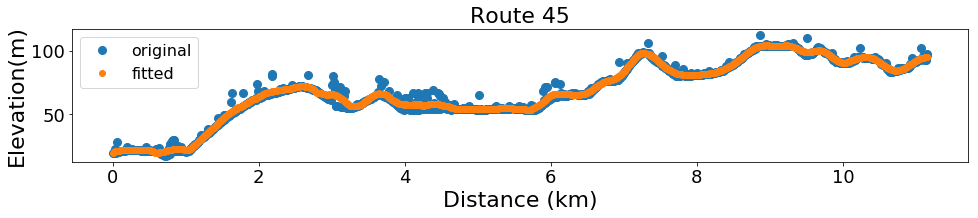

In [10]:
fig = plt.figure(figsize=(13.69,3.13)) #Connect all the fitted lines

ax1 = fig.add_subplot(111)
ax1.plot(data['Dist. Route (m)'].values/1000,data['Elev. Lidar (m)'],'o',label='original',ms = 8)
ax1.plot((data["Dist. Route (m)"].values)/1000,line,'o',label='fitted', lw = 3.5)
#ax1.plot((gps['Total Distance'].values/1000),gps['Elevation'],'o',label='altimeter',lw = 3)

#ax2 = ax1.twinx()
#ax2.plot(gps['Total Distance'].values/1000,gps['Speed'],'o',label='speed',ms= 5)

ax1.set_title('Route 45',fontsize = 22)
#ax1.set_xticks(np.arange(0,(data['Dist. Route (m)'][len(data)-1])/1000,2))

ax1.set_xlabel("Distance (km)",fontsize = 22)
ax1.set_ylabel("Elevation(m)",fontsize = 22)
ax1.legend(fontsize = 16)
plt.tight_layout()

In [11]:
delta = data['Elev. Lidar (m)']-line
avg = np.median(delta)
avg

-0.3400690415062968

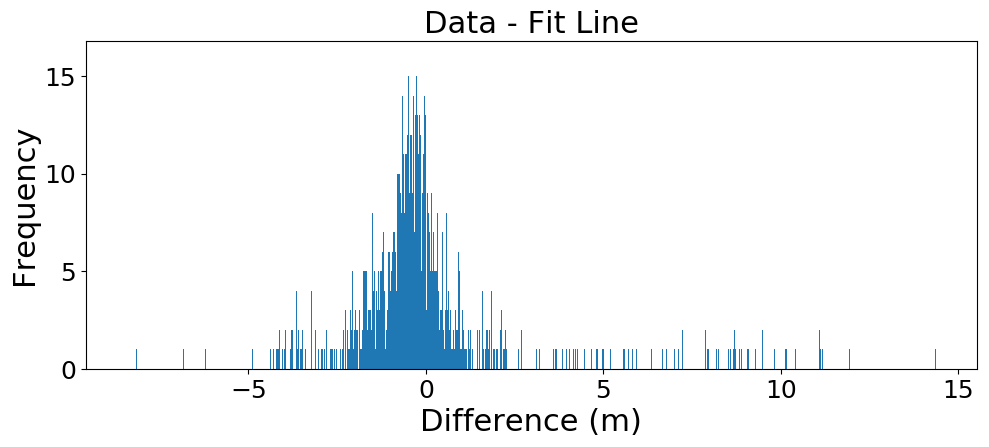

In [12]:
fig = plt.figure(figsize=(10,8), dpi =100)
ax1 = fig.add_subplot(211)

ax1.hist(delta,bins = len(line))

ax1.set_title('Data - Fit Line',fontsize = 22)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.set_xlabel("Difference (m)",fontsize = 22)
ax1.set_ylabel("Frequency",fontsize = 22)
plt.tight_layout()

In [13]:
working=[0]
for i in range(1,len(data)):
    oldslope=((data['Elev. Lidar (m)'][i]-data['Elev. Lidar (m)'][i-1])/(data['Dist. Route (m)'][i]-data['Dist. Route (m)'][i-1]))*100
    working.append(oldslope)
data['slope'] = working

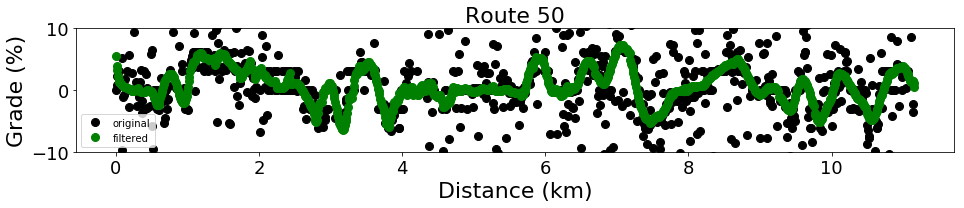

In [14]:
fig = plt.figure(figsize=(13.5,3))

ax1 = fig.add_subplot(111)
ax1.set_title('Route 50',fontsize = 22)
ax1.plot((data["Dist. Route (m)"].values)/1000,data['slope'],'o',label='original',color = 'k',ms = 8)
ax1.plot((data["Dist. Route (m)"].values)/1000,grade,'o',label='filtered',color = 'g',ms = 8)
#ax1.plot(grade.index,grade,'o-',label='filtered')

ax1.set_xticks(np.arange(0,(data['Dist. Route (m)'][len(data)-1])/1000,2))
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.set_xlabel("Distance (km)",fontsize = 22)
ax1.set_ylabel("Grade (%)",fontsize = 22)
ax1.legend()
ax1.set_ylim(-10,10)
#ax1.set_xlim(0,50)
#ax1.legend()
#ax1.title("Route 5")
plt.tight_layout()

In [15]:
#Plot for comparing filtered LiDAR elevation data to collected data
#fig = plt.figure(figsize=(13.69,3.13)) #Connect all the fitted lines

#plotdata = data.iloc[400:450]
#plotline = line[400:450]
#plotgps = gps.iloc[140:155]

#ax1 = fig.add_subplot(111)
#ax1.plot(plotdata['Dist. Route (m)'].values/1000,plotdata['Elev. Lidar (m)'],'o',label='original (LiDAR)',ms = 8)
#ax1.plot((plotdata["Dist. Route (m)"].values)/1000,plotline,'-',label='fitted', lw = 3.5)
#ax1.plot((plotgps['Total Distance'].values/1000),plotgps['Elevation'],'s',label='altimeter',ms = 10)
#ax1.plot(data['Dist. Route (m)'].values/1000,data['Literature'],'o',label='literature',ms= 5)

#ax1.set_title('Route 45',fontsize = 22)
#ax1.set_xticks(np.arange(0,(data['Dist. Route (m)'][len(data)-1])/1000,2))
#ax1.tick_params(axis='both', which='major', labelsize=18)
#ax1.set_xlabel("Distance (km)",fontsize = 22)
#ax1.set_ylabel("Elevation(m)",fontsize = 22)
#ax1.legend(fontsize = 16)
#plt.tight_layout()

In [16]:
#Now, calculating the forces on the bus

forces = pd.DataFrame()

#Calculate the gravitational force 
forces['Fg'] = mass * g * np.asarray(sin)

#Calculate the rolling friction
forces['Fr'] = fr * mass * g * np.asarray(cos)

#Calculate the inertial force
forces['Fi'] = mass * (data['Accel (m/s^2)'])

#Calculate the aerodynamic drag
forces['Fa'] = cd * A * (rhoa/2)*(data['Velocity (m/s)']-5)

forces.head()

,Fg,Fr,Fi,Fa
0,6949.154566,1266.233267,0.0,-8.933925
1,5017.559348,1267.145679,12927.0,0.000000
2,4091.442962,1267.478509,9048.9,1.786785
3,2884.455127,1267.810615,9048.9,3.573570
4,2178.018205,1267.951650,9048.9,5.360355


In [25]:
#Calculate torque/load

#forces['torque (N*m)'] = (forces['Fg']+forces['Fr']+forces['Fi']+forces['Fa'])*rw
forces['Power (w)'] = (forces['Fg']+forces['Fr']+forces['Fi']+forces['Fa'])*data['Velocity (m/s)']
forces.head(11)

,Fg,Fr,Fi,Fa,torque (N*m),Power (w)
0,6949.154566,1266.233267,0.0,-8.933925,2344.994204,0.000000
1,5017.559348,1267.145679,12927.0,0.000000,5489.744711,96058.525135
2,4091.442962,1267.478509,9048.9,1.786785,4117.545559,86457.649537
3,2884.455127,1267.810615,9048.9,3.573570,3773.254258,92433.175179
4,2178.018205,1267.951650,9048.9,5.360355,3571.940783,100001.841681
5,1718.793861,1268.022215,9048.9,7.147140,3441.248164,108385.768938
6,1409.690738,1268.060345,9048.9,8.933925,3353.443416,117355.850087
7,1216.675776,1268.080334,0.0,10.720710,713.082501,27450.245014
8,1083.878463,1268.092380,0.0,10.720710,675.139111,25989.607079
9,975.408874,1268.101187,0.0,10.720710,644.146443,24796.538481


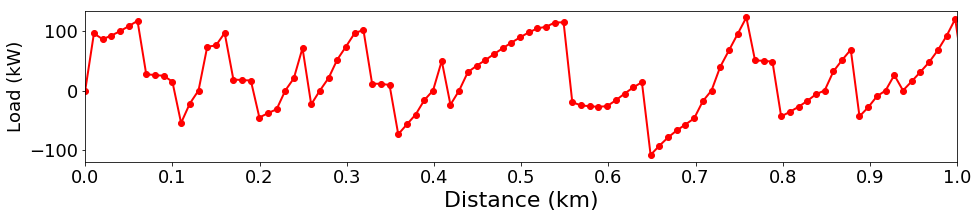

In [51]:
fig = plt.figure(figsize=(13.69,3.13)) #Connect all the fitted lines

ax = fig.add_subplot(111)
#ax1.plot(data['Dist. Route (m)'].values/1000,line,'o',label='Elevation (m)',ms = 8)

#ax2 = ax1.twinx()
ax.plot((data["Dist. Route (m)"].values)/1000,forces['Power (w)']/1000,'-o', lw = 2,color = 'r')
#ax1.plot((gps['Total Distance'].values/1000),gps['Elevation'],'o',label='altimeter',lw = 3)
#ax1.plot(data['Dist. Route (m)'].values/1000,data['Literature'],'o',label='literature',ms= 5)

#ax1.set_title('Route 45',fontsize = 22)
ax.set_xticks(np.arange(0, 1.1, step=0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.tick_params(axis='both', labelsize=18)
ax.set_xlabel("Distance (km)",fontsize = 22)
ax.set_xlim(0,1)
#ax1.set_ylabel("Grade(%)",fontsize = 18)
#ax1.set_ylim(15,25)
ax.set_ylabel("Load (kW)",fontsize=18)
#fig.legend(fontsize = 16)
plt.tight_layout()
plt.savefig('1_24.png')

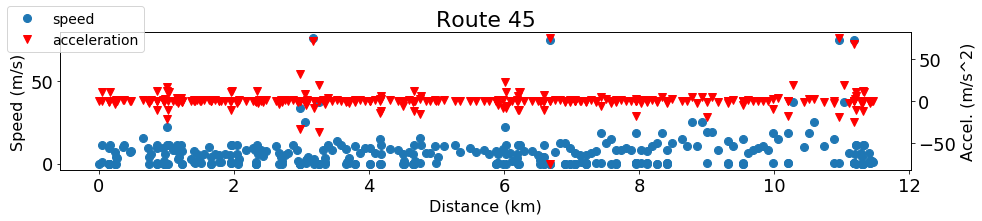

In [27]:
fig = plt.figure(figsize=(13.69,3.13)) #Connect all the fitted lines

plotgps = gps.iloc[0:1200]

ax1 = fig.add_subplot(111)
ax1.plot(plotgps['Total Distance'].values/1000,plotgps['Speed'],'o',label='speed',ms = 8)

ax2 = ax1.twinx()
ax2.plot(plotgps['Total Distance'].values/1000,plotgps['Accel.'],'v',label='acceleration',color = 'r',ms=8)
#ax1.plot((gps['Total Distance'].values/1000),gps['Elevation'],'o',label='altimeter',lw = 3)
#ax1.plot(data['Dist. Route (m)'].values/1000,data['Literature'],'o',label='literature',ms= 5)

ax1.set_title('Route 45',fontsize = 22)
#ax1.set_xticks(np.arange(0,(data['Dist. Route (m)'][len(data)-1])/1000,2))
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', labelsize=18)
ax1.set_xlabel("Distance (km)",fontsize = 16)
ax1.set_ylabel("Speed (m/s)",fontsize = 16)
ax2.set_ylabel("Accel. (m/s^2)",fontsize = 16)
fig.legend(fontsize = 14,loc = 2)
plt.tight_layout()

In [106]:
forces['torque (N*m)'].max()

4897.527622122828